## Loading Tools and Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaleido
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from skgstat import DirectionalVariogram, OrdinaryKriging
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

df_clean = pd.read_csv('../data/clean_gaswells.csv')
df_encoded = pd.read_csv('../data/encoded_gaswells.csv')
df_county = pd.read_csv('../data/county_gaswells.csv')

## Gas Wells Overview

In [16]:
df = df_clean.copy()
fig = px.scatter_mapbox(
    df,
    lat='latitude',
    lon='longitude',
    size_max=15,
    color='gas_prod',
    color_continuous_scale='plasma',
    opacity=0.7,
    zoom=5.5,
    mapbox_style='carto-positron',
    title='NYS Overview of Gas Production')

fig.update_layout(
    title='NYS DEC Gas Production (2000-2024)',
    title_x=0.5,
    title_y=0.95,
    title_font_size=20,
    coloraxis_colorbar=dict(
        title="Gas (MCF)"
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox=dict(
        center=dict(lat=43, lon=-77),
        zoom=5.75))

fig.show()

In [17]:
df = df_clean.copy()
fig = px.scatter_mapbox(
    df,
    lat='latitude',
    lon='longitude',
    size_max=15,
    color='gas_prod',
    color_continuous_scale='plasma',
    opacity=0.7,
    zoom=5.5,
    mapbox_style='carto-positron')

fig.update_layout(
    title='Zoomed-In Hotspots, Syracuse Area',
    title_x=0.5,
    title_y=0.95,
    title_font_size=20,
    title_font_weight='bold',
    coloraxis_colorbar=dict(
        title="Gas (MCF)"
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox=dict(
        center=dict(lat=42.94331, lon=-76.44638),
        zoom=9))

fig.show()
pio.write_image(fig, '../images/syracuse_wells.png')

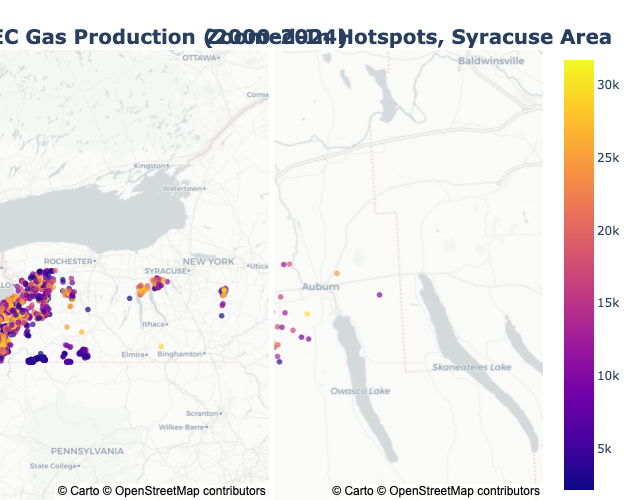

In [198]:
df = df_clean.copy()
fig1 = px.scatter_mapbox(
    df,
    lat='latitude',
    lon='longitude',
    size_max=15,
    color='gas_prod',
    color_continuous_scale='plasma',
    opacity=0.7,
    zoom=5.5,
    mapbox_style='carto-positron')

fig2 = px.scatter_mapbox(
    df,
    lat='latitude',
    lon='longitude',
    size_max=15,
    color='gas_prod',
    color_continuous_scale='plasma',
    opacity=0.7,
    zoom=9,
    mapbox_style='carto-positron')

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("NYS DEC Gas Production (2000-2024)", "Zoomed-In Hotspots, Syracuse Area"),
    horizontal_spacing=0.01,
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}]])

for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=20, weight='bold')

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_layout(
    mapbox1=dict(
        center=dict(lat=43, lon=-77),
        zoom=5.5,
        style='carto-positron'
    ),
    mapbox2=dict(
        center=dict(lat=42.94331, lon=-76.44638),
        zoom=9,
        style='carto-positron'
    ),
    margin={"r":0,"t":50,"l":0,"b":0},
    width=1200,
    height=500)

fig.show()
pio.write_image(fig, '../images/nys_gaswells.png')

## Spatial Correlation

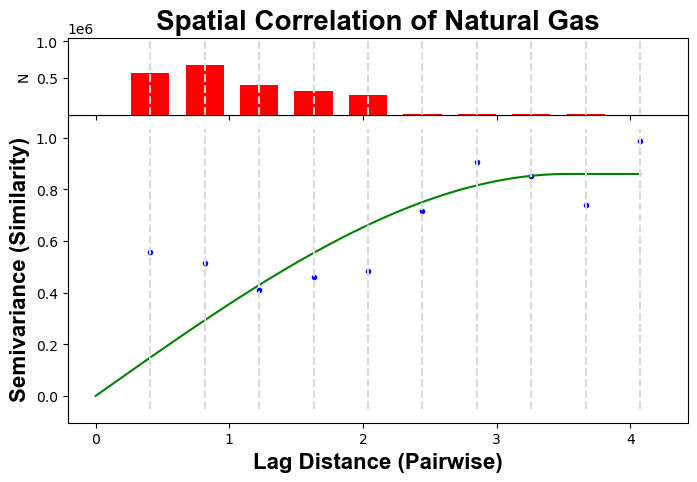

In [27]:
df = df_encoded.copy()
coords = np.array(df[['num__longitude', 'num__latitude']].values)
vals = np.array(df['num__gas_prod'].values)

V = DirectionalVariogram(
    coordinates=coords,
    values=vals.flatten())

fig = V.plot()
axes = fig.get_axes()
variogram_ax = axes[0]
plt.title('Spatial Correlation of Natural Gas', font='arial', fontweight='bold', fontsize=20)
variogram_ax.set_xlabel('Lag Distance (Pairwise)', font='arial', color='black', fontweight='bold', fontsize=16)
variogram_ax.set_ylabel('Semivariance (Similarity)', font='arial', color='black', fontweight='bold', fontsize=16)

fig.savefig('../images/base_variogram.png')

## Exploratory Data Analysis

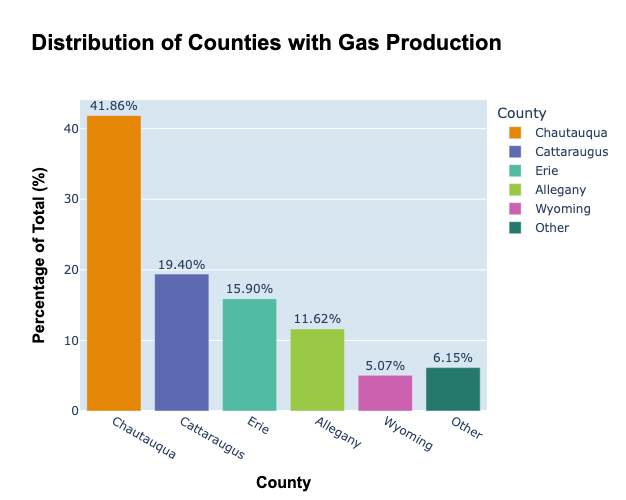

In [195]:
df = df_county.copy()
county_counts = df['County'].value_counts().reset_index()
county_counts.columns = ['County', 'Count']

total_count = county_counts['Count'].sum()
county_counts['Percentage'] = (county_counts['Count'] / total_count) * 100

threshold = 100
grouped_county_counts = county_counts.copy()
grouped_county_counts.loc[grouped_county_counts['Count'] <= threshold, 'County'] = 'Other'

grouped_county_counts = grouped_county_counts.groupby('County').sum().reset_index()
grouped_county_counts['Percentage'] = (grouped_county_counts['Count'] / total_count) * 100

ordered_categories = grouped_county_counts[grouped_county_counts['County'] != 'Other'].sort_values(by='Percentage', ascending=False)['County'].tolist()
ordered_categories.append('Other')

fig = px.bar(grouped_county_counts, x='County', y='Percentage',
             title='Distribution of Counties with Gas Production',
             labels={'Percentage':'Percentage of Total (%)', 'County':'County'},
             text='Percentage',
             category_orders={'County': ordered_categories},
             color='County',
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='rgba(216, 230, 241, 1)',
    height=500,
    title={
        'font': dict(
            size=22,  # Font size
            color='black',  # Font color
            family='Arial, sans-serif',  # Font family
            weight='bold',  # Font weight (can be 'bold', 'normal', etc.)
        )},
    xaxis=dict(
        title='County',
        titlefont=dict(size=16, color='black', family='Arial, sans-serif', weight='bold'),  # Bold x-axis title
    ),
    yaxis=dict(
        title='Percentage of Total (%)',
        titlefont=dict(size=16, color='black', family='Arial, sans-serif', weight='bold'),  # Bold y-axis title
    )
)
fig.show()
pio.write_image(fig, '../images/county_distribution.png')

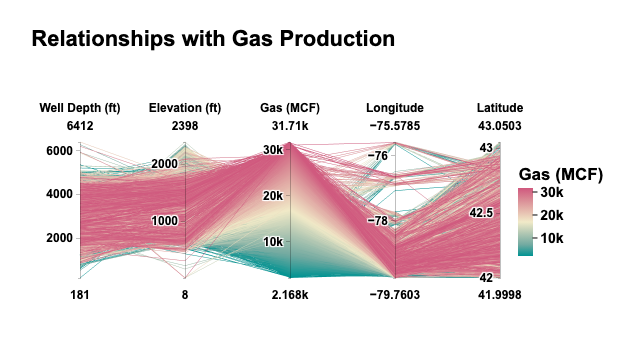

In [196]:
df = df_county.copy()
renamed_labels = {
    'depth': 'Well Depth (ft)',
    'elevation': 'Elevation (ft)',
    'gas_prod': 'Gas (MCF)',
    'longitude': 'Longitude',
    'latitude': 'Latitude'}

fig = px.parallel_coordinates(
    df,
    color='gas_prod',
    dimensions=['depth', 'elevation', 'gas_prod', 'longitude', 'latitude'],
    labels=renamed_labels,
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="Relationships with Gas Production")

fig.update_layout(
    title={
        'text': "Relationships with Gas Production",
        'y':0.915,
        'font': dict(
            size=22, 
            color='black',
            family='Arial, sans-serif', 
            weight='bold')},
    paper_bgcolor='white', 
    plot_bgcolor='rgba(0,0,0,0)', 
    font=dict(
        color='black',
        size=14,
        family='Arial, sans-serif',
        weight='bold'),
    margin=dict(t=140),
    coloraxis_colorbar=dict(
        title="Gas (MCF)", 
        thickness=15,
        len=0.8,
        yanchor="middle",
        y=0.5,
        ticks="outside",
        ticklen=5,
        tickcolor='black'))

fig.show()
pio.write_image(fig, '../images/feature_relationships.png')

## Map

In [213]:
import numpy as np
import pandas as pd
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import json

# init app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Load data
grid_data = pd.read_parquet('../data/kriging_grid_data.parquet')
well_data = pd.read_csv('../data/clean_gaswells.csv')
with open('../data/new_york_counties.json') as f:
    ny_geojson = json.load(f)

# Process well data
def process_well_data(well_data):
    size = np.interp(well_data['gas_prod'], 
                     (well_data['gas_prod'].min(), well_data['gas_prod'].max()), 
                     (10, 30))
    
    well_data['marker_size'] = size
    well_data['marker_border_size'] = size + 2

    customdata = np.stack([
        well_data['longitude'].round(2),
        well_data['latitude'].round(2),
        well_data['gas_prod'],
        well_data['depth'],
        well_data['elevation'],
        well_data['well'],
        well_data['status'],
        well_data['field'],
        well_data['geology']
    ], axis=-1)

    return well_data, customdata

well_data, well_customdata = process_well_data(well_data)

# App layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("New York Kriging Dashboard", className="text-center"), className="mb-4 mt-4")
    ]),
    dbc.Row([
        dbc.Col([
            html.Div([
                dcc.Graph(id='choropleth-map', config={'scrollZoom': True}),
                html.Div([
                    dbc.Card([
                        dbc.CardHeader("Map Layers"),
                        dbc.CardBody([
                            dcc.Checklist(
                                id='layer-toggle',
                                options=[
                                    {'label': 'Interpolation', 'value': 'kriging'},
                                    {'label': 'Error Map', 'value': 'error'},
                                    {'label': 'Well Locations', 'value': 'wells'}
                                ],
                                value=['kriging']
                            )
                        ])
                    ], style={"width": "12rem"})
                ], style={
                    'position': 'absolute',
                    'bottom': '10px',
                    'right': '120px',
                    'z-index': '1000',
                    'background-color': 'rgba(255, 255, 255, 0.8)'
                })
            ], style={'position': 'relative'})
        ], width=12)
    ]),
], fluid=True)

# Update map
@app.callback(
    Output('choropleth-map', 'figure'),
    [Input('layer-toggle', 'value')]
)
def update_map(layers):
    fig = go.Figure()

    fig.update_layout(
        mapbox=dict(
            style="carto-positron",
            zoom=6,  # Zoomed out to show the world by default
            center={"lat": 43.0, "lon": -77.0}  # World centered view
        ),
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    if 'kriging' in layers:
        kriging_layer = go.Choroplethmapbox(
            geojson=ny_geojson,
            locations=grid_data['GEOID'],  # Match this to your geojson IDs
            z=grid_data['predicted_value'],
            colorscale="plasma",
            marker_opacity=0.7,
            zmin=grid_data['predicted_value'].min(),
            zmax=grid_data['predicted_value'].max(),
            colorbar=dict(title="Gas (MCF)"),
            featureidkey="properties.GEOID",  # Ensuring this aligns with geojson
        )
        fig.add_trace(kriging_layer)

    if 'error' in layers:
        error_layer = go.Choroplethmapbox(
            geojson=ny_geojson,
            locations=grid_data['GEOID'],  # Match this to your geojson IDs
            z=grid_data['error'],
            colorscale="YlGn_r",
            marker_opacity=0.7,
            zmin=grid_data['error'].min(),
            zmax=grid_data['error'].max(),
            colorbar=dict(title="Variance"),
            featureidkey="properties.GEOID",  # Ensuring this aligns with geojson
        )
        fig.add_trace(error_layer)

    if 'wells' in layers:
        border_scatter = go.Scattermapbox(
            lat=well_data['latitude'],
            lon=well_data['longitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=well_data['marker_border_size'],
                color='black',
                opacity=0.8,
                symbol='circle'
            ),
            showlegend=False,
            hoverinfo='skip'
        )
        
        well_scatter = go.Scattermapbox(
            lat=well_data['latitude'],
            lon=well_data['longitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=well_data['marker_size'],
                color=well_data['gas_prod'],
                colorscale='Plasma',
                cmin=well_data['gas_prod'].min(),
                cmax=well_data['gas_prod'].max(),
                opacity=0.8,
                symbol='circle'
            ),
            customdata=well_customdata,
            hovertemplate=(
                "Longitude: %{customdata[0]}<br>"
                "Latitude: %{customdata[1]}<br>"
                "Gas Produced: %{customdata[2]}<br>"
                "Depth: %{customdata[3]}<br>"
                "Elevation: %{customdata[4]}<br>"
                "Well Type: %{customdata[5]}<br>"
                "Well Status: %{customdata[6]}<br>"
                "Field: %{customdata[7]}<br>"
                "Geology: %{customdata[8]}<extra></extra>"
            ),
            name='Well Locations',
            showlegend=False,
        )

        fig.add_traces([border_scatter, well_scatter])

    if layers:
        fig.update_layout(
            mapbox=dict(
                zoom=6,  # Zoom into New York
                center={"lat": 43.0, "lon": -77.0}  # New York centered view
            )
        )

    return fig

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

In [212]:
import numpy as np
import pandas as pd
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import json

# init app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Load data
grid_data = pd.read_parquet('../data/kriging_grid_data.parquet')
well_data = pd.read_csv('../data/clean_gaswells.csv')
with open('../data/new_york_counties.json') as f:
    ny_geojson = json.load(f)

# Process well data
def process_well_data(well_data):
    size = np.interp(well_data['gas_prod'], 
                     (well_data['gas_prod'].min(), well_data['gas_prod'].max()), 
                     (10, 30))
    
    well_data['marker_size'] = size
    well_data['marker_border_size'] = size + 2

    customdata = np.stack([
        well_data['longitude'].round(2),
        well_data['latitude'].round(2),
        well_data['gas_prod'],
        well_data['depth'],
        well_data['elevation'],
        well_data['well'],
        well_data['status'],
        well_data['field'],
        well_data['geology']
    ], axis=-1)

    return well_data, customdata

well_data, well_customdata = process_well_data(well_data)

# App layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("New York Kriging Dashboard", className="text-center"), className="mb-4 mt-4")
    ]),
    dbc.Row([
        dbc.Col([
            html.Div([
                dcc.Graph(id='choropleth-map', config={'scrollZoom': True}),
                html.Div([
                    dbc.Card([
                        dbc.CardHeader("Map Layers"),
                        dbc.CardBody([
                            dcc.Checklist(
                                id='layer-toggle',
                                options=[
                                    {'label': 'Interpolation', 'value': 'kriging'},
                                    {'label': 'Error Map', 'value': 'error'},
                                    {'label': 'Well Locations', 'value': 'wells'}
                                ],
                                value=['kriging']
                            )
                        ])
                    ], style={"width": "12rem"})
                ], style={
                    'position': 'absolute',
                    'bottom': '10px',
                    'right': '120px',
                    'z-index': '1000',
                    'background-color': 'rgba(255, 255, 255, 0.8)'
                })
            ], style={'position': 'relative'})
        ], width=12)
    ]),
], fluid=True)

@app.callback(
    Output('choropleth-map', 'figure'),
    [Input('layer-toggle', 'value')]
)
def update_map(layers):
    fig = go.Figure()

    fig.update_layout(
        mapbox=dict(
            style="carto-positron",
            zoom=6,  # Zoom into New York
            center={"lat": 43.0, "lon": -77.0}  # New York centered view
        ),
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    if 'kriging' in layers:
        density_layer = go.Densitymapbox(
            lat=grid_data['lat'],  # Replace with your grid latitude column
            lon=grid_data['lon'],  # Replace with your grid longitude column
            z=grid_data['predicted_value'],  # The value to interpolate
            radius=10,  # Adjust this for more or less smoothing
            colorscale="plasma",
            zmin=grid_data['predicted_value'].min(),
            zmax=grid_data['predicted_value'].max(),
            opacity=0.6,
            showscale=True,
            colorbar=dict(title="Gas (MCF)")
        )
        fig.add_trace(density_layer)

    if 'error' in layers:
        error_layer = go.Densitymapbox(
            lat=grid_data['lat'],  # Replace with your grid latitude column
            lon=grid_data['lon'],  # Replace with your grid longitude column
            z=grid_data['error'],  # The error values
            radius=10,  # Adjust the radius as needed
            colorscale="YlGn_r",
            zmin=grid_data['error'].min(),
            zmax=grid_data['error'].max(),
            opacity=0.6,
            showscale=True,
            colorbar=dict(title="Variance")
        )
        fig.add_trace(error_layer)

    if 'wells' in layers:
        well_data_sampled = well_data.sample(frac=0.1)  # Reduce the data to 10% for performance

        well_scatter = go.Scattermapbox(
            lat=well_data_sampled['latitude'],
            lon=well_data_sampled['longitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=well_data_sampled['marker_size'] / 2,  # Reduce marker size
                color=well_data_sampled['gas_prod'],
                colorscale='Plasma',
                cmin=well_data_sampled['gas_prod'].min(),
                cmax=well_data_sampled['gas_prod'].max(),
                opacity=0.7,
                symbol='circle'
            ),
            customdata=well_customdata,
            hovertemplate=(
                "Longitude: %{customdata[0]}<br>"
                "Latitude: %{customdata[1]}<br>"
                "Gas Produced: %{customdata[2]}<br>"
                "Depth: %{customdata[3]}<br>"
                "Elevation: %{customdata[4]}<br>"
                "Well Type: %{customdata[5]}<br>"
                "Well Status: %{customdata[6]}<br>"
                "Field: %{customdata[7]}<br>"
                "Geology: %{customdata[8]}<extra></extra>"
            ),
            name='Well Locations',
            showlegend=False,
        )

        fig.add_trace(well_scatter)

    return fig

# Run app
if __name__ == '__main__':
    app.run_server(debug=True)

## Script

In [197]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
